In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

### 1. Data Preparation

In this section, the cleaned dataset in csv format is read into pandas. The geojson shape files are also read into geopandas. A specific region is selected and multiple arrays are created in numpy to benefit from vectorisation. The datasets are split into primary and secondary enrollment and location (lat/lon) data - i.e. 4 arrays in total. 


In [457]:
# read in the prepared dataset. Evaluate point data to make it readible by geopandas
df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})

In [458]:
# Filter to only one region, and read in geojson file.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'
gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
# limit geojson to only selected region
gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
# limit clean dataset to only selected region
df = df.loc[df['region'] == region]

In [459]:
df['gr_offer'].value_counts()

G.1-8    2
Name: gr_offer, dtype: int64

In [460]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
# df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy()
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
# df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
# df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc])
# df_sec_loc = np.array([np.array(i) for i in df_sec_loc])

### 2. Create helper functions

##### 1. Shape Function. 
This function estimates the secondary level enrollment based on how close the primary school is to the secondary school. If the school is within 2km, an estimated 30 minutes for children, the full enrollment is possible. Therefore full enrollment is returned. If enrollment is greater than 5km, then zero enrollment is expected as it is a walk of 75 minutes each way. The school is too far and low enrollment is expected. Between 2km-5km, a minmax scaling is used to aassume a linear dropoff in enrollment.

Assumption here is : 
1km represents approximately 15 minutes’ walk for children, 2km: 30mins, 3km: 45 mins etc. (SRJIE ARTICLE)

In [461]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    return np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))

##### 2. Check Region Function. 

A function that takes as input a vector of [lat,lon] points and checks to see if it's within the region being proposed. This is necessary because CMA will propose solutions within a box boundary and some of the locations will not be within the region. Since the solutions proposed are at a regional basis, this is a necessary operation.


In [462]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

##### 3. Expected Enrollment Function

This function estimates the enrollment by calculating the distance of a proposed solution of new secondary schools to primary schools. If the primary school is within an adequate distance, determined by the shape function, then the enrollment is added to the expected enrollment. 


In [463]:
# cross check lat lon. 

In [578]:
distance

array([1.31660356, 0.76441914])

33976.26264865565

33976.26264865565

In [649]:
def expected_enrollment(prim_loc, prim_enroll, x):
    if check_woreda(x):
        # Check if all new locations are within the region, if not penalise with 0 enrollment
    #     x = np.append(sec_loc, x) # add proposed locations to current list of secondary schools
        distance = haversine_vector(prim_loc,x, Unit.KILOMETERS)
        enrollment2 = prim_enroll*.79901 # by enrollment proportion
        enrollment3 = shape(distance,enrollment2)
        return np.sum(enrollment3)
    else:
        return 0 # penalising all falling outside regional parameters.

#### 4. Objective Function F(x)

In [650]:
# The Objective Function
proposed_schools = 2
def f(x):
    """ The objective function which takes as input a 1d array.Every two elements 
    represent the lat/lon of a point in a given area. A locations variable is created
    which splits the points into pairs. The expected_enrollment function is then run 
    on this (5,2) list to return the total expected enrollment for the five locations.
    """
    locations = np.array(np.array_split(x, proposed_schools)) # change flatten split.
    test_case = expected_enrollment(df_prim_loc, df_prim_enroll, locations)
    return test_case*-1 # inverse of f(x) is needed as looking to maximise


### 3. Prepare CMA

#### 3.1. Create box boundaries

In [651]:
bounds = gdf_woreda_shp.bounds
bounds

,minx,miny,maxx,maxy
0,36.689328,10.713719,36.96973,10.964773


In [652]:
# Establish boundaries for CMA
# Latitude is the Y axis, longitude is the X axis.
bounds = gdf_woreda_shp.bounds
# bounds = gdf_region_shp.bounds
lat_bounds = bounds[['miny','maxy']].to_numpy()[0]
lon_bounds = bounds[['minx','maxx']].to_numpy()[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
bounds # array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]

array([[10.71371939, 36.68932805],
       [10.96477258, 36.96973029]])

In [653]:
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029])]

#### 3.2. Create starting point for CMA

In [654]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=2)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=2)
    sp = np.vstack((sp1, sp2)).T
    return sp

In [655]:
# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if check_woreda(sp) == True:
            sp = sp.flatten()
            return sp
            break
        else:
            sp = create_random_sp()

In [656]:
# it is latitude then longitude.
# haversine is also latitude then longitude.
get_random_sp()

array([10.87073529, 36.80804115, 10.75442487, 36.90650876])

In [657]:
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029])]

#### 3.3. Run CMA

In [658]:
sigma= (10.964773 - 10.713719)/4 # sigma should be 1/4th of the search domain width.
maxits=  10000
min_its = 10000
es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=0.2,
                          inopts={'bounds': boundsxy,'seed':1234})
es.optimize(f, iterations=min_its / es.popsize, min_iterations=1000)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1234, Fri Jun 24 16:11:10 2022)


TypeError: only size-1 arrays can be converted to Python scalars

In [522]:
# all solutions nearby are zero. min iterations forced to keep geenration 

In [642]:
es.result_pretty()

termination on tolfun=1e-11
termination on tolfunhist=1e-12
termination on tolstagnation=198
termination on noeffectaxis=None
termination on tolflatfitness=1
final/bestever f-value = 0.000000e+00 -3.303865e+08
incumbent solution: [10.955843916774858, 36.92065995525288, 10.941232781573715, 36.90373758784544]
std deviation: [1.1405334946221727e-05, 2.0635960453167767e-05, 4.475477529441544e-05, 6.485707254027547e-06]


CMAEvolutionStrategyResult(xbest=array([10.74936588, 36.93239622, 10.770435  , 36.90706893]), fbest=-330386459.63344103, evals_best=106, evaluations=8000, iterations=1000, xfavorite=array([10.95584392, 36.92065996, 10.94123278, 36.90373759]), stds=array([1.14053349e-05, 2.06359605e-05, 4.47547753e-05, 6.48570725e-06]), stop={'tolfun': 1e-11, 'tolfunhist': 1e-12, 'tolstagnation': 198, 'noeffectaxis': None, 'tolflatfitness': 1})

In [524]:
help(es.result)

Help on CMAEvolutionStrategyResult in module cma.evolution_strategy object:

class CMAEvolutionStrategyResult(CMAEvolutionStrategyResult)
 |  CMAEvolutionStrategyResult(xbest, fbest, evals_best, evaluations, iterations, xfavorite, stds, stop)
 |  
 |  A results tuple from `CMAEvolutionStrategy` property ``result``.
 |  
 |  This tuple contains in the given position and as attribute
 |  
 |  - 0 ``xbest`` best solution evaluated
 |  - 1 ``fbest`` objective function value of best solution
 |  - 2 ``evals_best`` evaluation count when ``xbest`` was evaluated
 |  - 3 ``evaluations`` evaluations overall done
 |  - 4 ``iterations``
 |  - 5 ``xfavorite`` distribution mean in "phenotype" space, to be
 |    considered as current best estimate of the optimum
 |  - 6 ``stds`` effective standard deviations, can be used to
 |    compute a lower bound on the expected coordinate-wise distance
 |    to the true optimum, which is (very) approximately stds[i] *
 |    dimension**0.5 / min(mueff, dimension

In [214]:
help(cma)

Help on package cma:

NAME
    cma

DESCRIPTION
    Package `cma` implements the CMA-ES (Covariance Matrix Adaptation
    Evolution Strategy).
    
    CMA-ES is a stochastic optimizer for robust non-linear non-convex
    derivative- and function-value-free numerical optimization.
    
    This implementation can be used with Python versions >= 2.7, namely,
    it was tested with 2.7, 3.5, 3.6, 3.7, 3.8.
    
    CMA-ES searches for a minimizer (a solution x in :math:`R^n`) of an
    objective function f (cost function), such that f(x) is minimal.
    Regarding f, only a passably reliable ranking of the candidate
    solutions in each iteration is necessary. Neither the function values
    itself, nor the gradient of f need to be available or do matter (like
    in the downhill simplex Nelder-Mead algorithm). Some termination
    criteria however depend on actual f-values.
    
    The `cma` module provides two independent implementations of the
    CMA-ES algorithm in the classes `cma

In [617]:
es.result[1]

-10000

In [251]:
bounds

,minx,miny,maxx,maxy
0,36.689328,10.713719,36.96973,10.964773


0.06276349999999997

In [220]:
36.689328 - 36.96973

-0.28040199999999516

In [197]:
es.result[0]

array([10.77928904, 36.93026041, 10.88441627, 36.76206976])

In [198]:
# Run CMA 5 times and keep track of output in dataframe.

# import time
# maxits=  100000
# cma_list = [[],[]]
# start_time2 = time.time()

# # Create an empty dataframe to store results
# data = {'Algorithm':[],'min': [], 'mean': [], 'stddev': [],'time':[]}
# df = pd.DataFrame(data)

# for seed in range(5):
#     es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=0.15,
#                               inopts={'bounds': boundsxy,'seed':1234})
#     es.optimize(f, iterations=maxits / es.popsize, min_iterations=1000)
#     best_solution_found = np.stack(np.array_split(es.result[0], 5),axis=0)
#     cma_list[0].append(es.result[1])
#     cma_list[1].append(best_solution_found)
    
# #End time of CMA
# cma_time = time.time() - start_time2
# cma_time

# CMA_append = ['CMA', int(min(cma_list[0])), int(np.mean(cma_list[0])),
#              int(np.std(cma_list[0])), cma_time]
# df.loc[len(df)] = CMA_append

In [199]:
es.result[1]

-23970.0

In [200]:
# Cross check to ensure all locations within boundary.
vec = np.array(np.array_split(es.result[0].flatten(),2))
vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
# vec.within(gdf_region_shp[0])
vec.within(gdf_woreda_shp[0])

array([ True,  True])

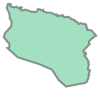

In [201]:
gdf_woreda_shp[0]

#### 3.4. Visualise Results

In [643]:
best_solution = np.array(np.array_split(es.result[0].flatten(), proposed_schools))

In [644]:
# formalise the basic problem by filtering the top enrollment. 
# explain in introduction what someone would do during optimisation and why this is better. 

In [645]:
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029])]

In [647]:
es.result

CMAEvolutionStrategyResult(xbest=array([10.74936588, 36.93239622, 10.770435  , 36.90706893]), fbest=-330386459.63344103, evals_best=106, evaluations=8000, iterations=1000, xfavorite=array([10.95584392, 36.92065996, 10.94123278, 36.90373759]), stds=array([1.14053349e-05, 2.06359605e-05, 4.47547753e-05, 6.48570725e-06]), stop={'tolfun': 1e-11, 'tolfunhist': 1e-12, 'tolstagnation': 198, 'noeffectaxis': None, 'tolflatfitness': 1})

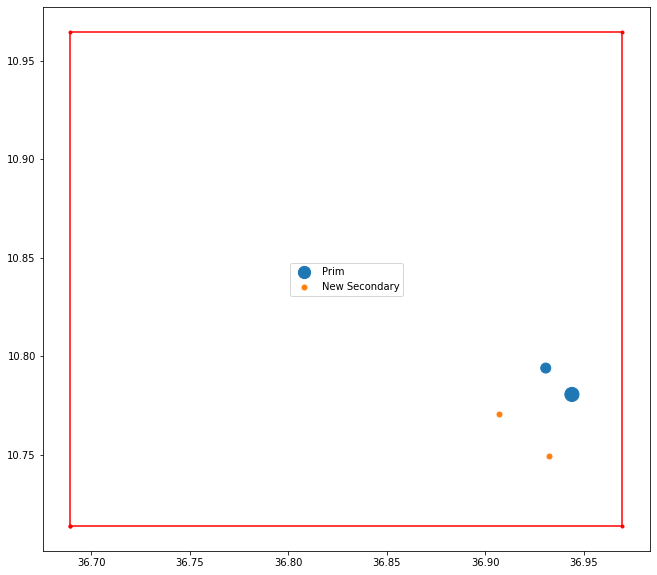

In [646]:
# it is latitude then longitude.
box = np.array([[10.713719, 36.689328], [10.713719, 36.96973],[10.964773, 36.96973], [10.964773, 36.689328], [10.713719, 36.689328]])
plt.figure(figsize=(15, 10))
plt.plot(box[:,1], box[:,0], '.r-')
plt.scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
plt.scatter(best_solution[:, 1], best_solution[:, 0], s = 25, marker="o", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [572]:
distance

array([1.31660356, 0.76441914])

In [ ]:
box = [[10.713719, 36.689328], [10.964773]]

In [ ]:
# add some labels and create an even smaller dataset. 

In [ ]:
# ff = np.array_split(es.result[0],5)

# enrol = 0
# for i in ff:
#     dist = np.min(haversine_vector(df_prim_loc, i, Unit.KILOMETERS, comb=True))
#     enrol_index = np.argmin(haversine_vector(df_prim_loc,i, Unit.KILOMETERS, comb=True))
#     enroly = shape(dist, (df_prim_enroll[enrol_index]*.79901))
#     enrol += enroly
#     print('Distance: ', round(dist,2), '\n',
#           'Index: ', enrol_index,'\n', 
#           'Shaped Enrollment: ',int(enroly),'\n',
#           'Accumulative Enrollment: ', int(enrol),'\n',
#           'Coordinates: ', i)

In [ ]:
enrol

In [ ]:
distance

In [334]:
# Check if all new locations are within the region, if not penalise with 0 enrollment
x = np.append(sec_loc, x) # add proposed locations to current list of secondary schools
#     x = np.array(np.array_split(x, (len(df_sec_loc)+proposed_schools)))
distance = np.min(haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)
#         enrollment = df_prim_enroll[np.argmin(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)]
enrollment = prim_enroll*.79901 # by enrollment proportion
expected_enrollment = np.sum(shape(distance,enrollment))

return expected_enrollment

NameError: name 'prim_loc' is not defined

In [366]:
distance = np.min(haversine_vector(ff,df_prim_loc, Unit.KILOMETERS, comb=True), axis=0)
distance

array([21.60823106,  1.08205839])

In [368]:
secondary_enrollment[school_distance]

array([[0],
       [0]])

In [648]:
ff = np.array_split(es.result[0],2)
# x = np.array(np.array_split(np.append(df_sec_loc, ff),len(df_sec_loc)+5))
# secondary_enrollment = np.array([[0],[0]])
distance = haversine_vector(df_prim_loc,ff, Unit.KILOMETERS)
enrollment2 = df_prim_enroll*.79901 # by enrollment proportion
enrollment3 = shape(distance,enrollment2)
np.prod(enrollment3*distance)

330386459.63344103

In [612]:
distance

array([27.1062364,  1.7591338])

In [422]:
a = [0,0]

True

In [384]:

secondary_enrollment

array([[    0],
       [23970]])

In [374]:
np.insert(secondary_enrollment, school_distance, enrollment3)

array([    0, 15980,  7990,     0])

In [354]:
secondary_enrollment

array([], dtype=[])

In [349]:
school_distance

array([1, 1], dtype=int64)

In [337]:
distance

array([1.08205839, 1.45198759])

In [341]:
es.result[0]

array([10.86595482, 36.7470118 , 10.79031634, 36.94355324])

In [342]:
df_prim_loc

array([[10.7806, 36.9441],
       [10.794 , 36.9308]])

In [343]:
distance

array([1.08205839, 1.45198759])

In [ ]:
df_prim_enroll

In [ ]:
enrollment3

In [ ]:
np.sum(df_sec_enroll)

In [ ]:
x

In [ ]:
df_sec_loc

In [ ]:
np.sum(enrollment3)

In [ ]:
es.result

In [ ]:
np.sum(enrollment3)- np.sum(df_sec_enroll)

In [ ]:
# add proposed locations to current list of secondary schools
enrol = 0
# enrollment1 = df_prim_enroll[np.argmin(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)]
enrollment2 = df_prim_enroll*.79901 # by enrollment proportion
enrollment3 = shape(distance,enrollment2)
enrol = np.sum(enrollment3)
print(int(enrol))

In [ ]:
enrollment2

In [ ]:
enrollment2

In [ ]:
enrollment3

In [ ]:
np.sum(df_sec_enroll) - enrol

In [ ]:
# even a smaller function. 

In [ ]:
# this is the secondary location that is closest.
feeder = np.argmin(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)
feeder

In [ ]:
enrollment1

In [ ]:
# this is the distance
dist = np.min(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)
dist

In [ ]:
shape(distance, df_prim_enroll)

In [ ]:
enrolf = 0
for i in range(0, len(feeder)):
    print(feeder[i], dist[i], shape(dist[i], df_prim_enroll[i]))
    enrolf += shape(dist[i], df_prim_enroll[i])

In [ ]:
enrolf

In [ ]:
df_prim_enroll

In [ ]:
df_prim_enroll

In [ ]:
distance

In [ ]:
distance.size

In [ ]:
enrollment1

In [ ]:
round(4.450e+0)

In [ ]:
enrollment

In [ ]:
df_prim_enroll

In [ ]:
print('Distance: ', distance, '\n',
      'Shaped Enrollment: ',np.rint(enrollment),'\n',
      'Accumulative Enrollment: ', enrol,'\n',
      'Coordinates: ', x)

In [ ]:
sum(enrollment)

In [ ]:
# Total new secondary enrolment with new 5 schools
abs(sum(df_sec_enroll)+int(enrol))

In [ ]:
sum(df_sec_enroll)

In [ ]:
enrol

In [ ]:
np.sum(df_sec_enroll)